#### FROM MNIST TO CELEBA TO CATANDDOG

In [7]:
import tensorflow as tf
import numpy as np
import os
import sys
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets("../data/MNIST_data/")

In [3]:
# plt.imshow(mnist.train.images[4].reshape(28,28))

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.50)

In [5]:
# image helper functions
def convert_to_tanh(im):
    #print("Converting Image in tanh range ... !")
    max_value = np.round(np.max(im))
    min_value = np.round(np.min(im))
    if(max_value == 1 and min_value == -1):
        #print("Array already in tanh range")
        return im
    return np.round(((im/max_value)*2)-1,decimals=2)

def convert_from_tanh(im):
    #print("Conveting image from tanh to 0-255 range")
    max_value = np.round(np.max(im))
    return np.round(((im+1)/2)*max_value,decimals=2)

In [8]:
# architeture helper functions
def relu(x):
    return tf.nn.relu(x)

def tanh(x):
    return tf.nn.tanh(x)

def lrelu(x):
    return tf.nn.leaky_relu(x)

def batch_norm(x):
    layer = tf.layers.batch_normalization(x)
    return layer

def linear(x,out_neuron,name):
    with tf.variable_scope(name):
        w = tf.get_variable(name='weights',shape=[x.get_shape()[1].value,out_neuron],initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable(name='biases',shape=[out_neuron],initializer=tf.constant_initializer())
        layer = tf.matmul(x,w)+b
    return layer

def conv2d(x,filter_size,in_channel,out_channel,stride,name,padding='same'):
    # default filter size (5,5)
    with tf.variable_scope(name):
        w = tf.get_variable(name='kernel',shape=[filter_size,filter_size,in_channel,out_channel],initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable(name='biases',shape=[out_channel],initializer=tf.constant_initializer())
        layer = tf.nn.conv2d(x,filter=w,strides=[1,stride,stride,1],padding=padding.upper())+b
    
    return layer

def deconv2d(x,in_channel,out_channel,stride,name,):
    with tf.variable_scope(name):
        w = tf.get_variable(name='kernel',shape=[5,5,out_channel,in_channel],initializer=tf.contrib.layers.xavier_initializer())
        out_w = x.get_shape()[1].value*stride
        out_h = x.get_shape()[2].value*stride
        if(x.get_shape()[0] == None):
            print("Placeholder Error : Define placeholder with batch_size instead of 'None' ")
            return None
        # outshape needs exact integers instead on None or -1
        out_shape = [x.get_shape()[0].value,out_w,out_h,out_channel]
        out_shape = tf.stack(out_shape)
        layer = tf.nn.conv2d_transpose(x,filter=w,output_shape=out_shape,strides=[1,stride,stride,1],padding='SAME')
        return layer

In [9]:
tf.reset_default_graph()
# image size should be multiple of 16
image_size = 128
image_channel = 3
z_shape = 100
batch_size = 32
maxpool_stride = 2
normal_stride = 1

df_size = 5 # dsicriminator filter
df_channel = 32
gf_size = image_size //16 # generator filter
gf_channel = 40

In [10]:
def DN(X,reuse=None):
    X = tf.reshape(X,shape=[-1,image_size,image_size,image_channel])
    with tf.variable_scope('dis',reuse=reuse):
        l1 = lrelu(conv2d(X,df_size,image_channel,df_channel,maxpool_stride,'l1'))
        l2 = lrelu(conv2d(l1,df_size,df_channel,df_channel*2,maxpool_stride,'l2'))
        l3 = lrelu(conv2d(l2,df_size,df_channel*2,df_channel*4,maxpool_stride,'l3'))
        l4 = lrelu(conv2d(l3,l3.get_shape()[1],df_channel*4,1024,normal_stride,'l4','valid')) # valid padding
        l5 = conv2d(l4,1,1024,1,normal_stride,'l5','valid') # valid padding
        output = tf.reshape(l5,shape=[-1,1*1*1])
        
        return output
    
    
    
def DN_bn(X,reuse=None):
    # no batch norm to discriminator input layer
    X = tf.reshape(X,shape=[-1,image_size,image_size,image_channel])
    with tf.variable_scope('dis',reuse=reuse):
        l1 = lrelu(conv2d(X,df_size,image_channel,32,maxpool_stride,'l1'))
        l2 = lrelu(batch_norm(conv2d(l1,df_size,32,64,maxpool_stride,'l2')))
        l3 = lrelu(batch_norm(conv2d(l2,df_size,64,128,maxpool_stride,'l3')))
        l4 = lrelu(batch_norm(conv2d(l3,l3.get_shape()[1],128,1024,normal_stride,'l4','valid'))) # valid padding
        l5 = conv2d(l4,1,1024,1,normal_stride,'l5','valid') # valid padding
        output = tf.reshape(l5,shape=[-1,1*1*1])
        
        return output

In [11]:
def GN(z,reuse=None):
    z = tf.reshape(z,shape=[-1,z_shape])
    with tf.variable_scope('gen'):
        l1 = relu(linear(z,gf_size*gf_size*gf_channel,'l1'))
        l1 = tf.reshape(l1,[-1,gf_size,gf_size,gf_channel])
        l2 = relu(deconv2d(l1,gf_channel,gf_channel//2,2,'l2'))
        l3 = relu(deconv2d(l2,gf_channel//2,gf_channel//4,2,'l3'))        
        l4 = relu(deconv2d(l3,gf_channel//4,gf_channel//8,2,'l4'))  
        l5 = tanh(deconv2d(l4,gf_channel//8,image_channel,2,'l5'))
        
        return l5
    
def GN_bn(z,reuse=None):
    # no batch norm to generator output layer
    z = tf.reshape(z,shape=[-1,z_shape])
    with tf.variable_scope('gen'):
        l1 = relu(batch_norm(linear(z,gf_size*gf_size*gf_channel,'l1')))
        l1 = tf.reshape(l1,[-1,gf_size,gf_size,gf_channel])
        l2 = relu(batch_norm(deconv2d(ll1,gf_channel,gf_channel//2,2,'l2')))
        l3 = relu(batch_norm(deconv2d(l2,gf_channel//2,gf_channel//4,2,'l3')))        
        l4 = relu(batch_norm(deconv2d(l3,gf_channel//4,gf_channel//8,2,'l4')))  
        l5 = tanh(deconv2d(l4,gf_channel//8,image_channel,2,'l5'))
        
        return l5

In [12]:
real_image = tf.placeholder(tf.float32,shape=[batch_size,image_size,image_size,image_channel])
z = tf.placeholder(tf.float32,shape=[batch_size,z_shape])

In [13]:
with tf.name_scope('logits'):
    fake_image = GN(z)
    real_p = DN(real_image)
    fake_p = DN(fake_image,reuse=True)

In [14]:
with tf.name_scope('varaibles'):
    allvars = tf.trainable_variables()
    dvars = [var for var in allvars if 'dis' in var.name]
    gvars = [var for var in allvars if 'gen' in var.name]

In [15]:
# gan loss
# dloss = -tf.reduce_mean( tf.log(real_p) + tf.log(1. - fake_p) )
# gloss = -tf.reduce_mean( tf.log(fake_p) )

In [16]:
# wgan loss
dloss = -tf.reduce_mean(real_p - fake_p)
gloss = -tf.reduce_mean(fake_p)
clip_d = [p.assign(tf.clip_by_value(p,-0.01,0.01)) for p in dvars]

In [17]:
# wgan-gp loss
# dloss = -tf.reduce_mean(real_p-fake_p)
# gloss = -tf.reduce_mean(fake_p)

# alpha= tf.random_uniform(shape=[1], minval=0.,maxval=1.)
# differences = fake_image - real_image 
# interpolates = real_image + (alpha*differences)
# gradients = tf.gradients(DN(interpolates,name='inter_discriminator'), [interpolates])[0]
# slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
# gradient_penalty = tf.reduce_mean((slopes-1.)**2)
# dloss += _lambda*gradient_penalty

In [18]:
doptimizer = tf.train.RMSPropOptimizer(learning_rate=0.00005).minimize(dloss,var_list=dvars)
goptimizer = tf.train.RMSPropOptimizer(learning_rate=0.00005).minimize(gloss,var_list=gvars)

In [20]:
from data import *
next_element,total_image_count,iter_init_op = get_data('../data/celebA/',image_size,image_size,image_channel,batch_size)

Total Images found : 202599
Creating batches of 32
Done reading .. !


In [25]:
n_critic = 5
total_epoch = 100
generated_images = []
dloss_x = []
dloss_y = []
gloss_x = []
gloss_y = []

In [ ]:
# main loop
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    sess.run(iter_init_op)
    
    print("<---- Started training ... .! ----> \n")
    for epoch in range(total_epoch):
        
        
        count = 0
        iterations = 0
        print("\nOn epoch : {}".format(epoch))
        
        while(iterations < total_image_count//batch_size):
            
            for _ in range(n_critic):
                # get the images
                ximage = sess.run(next_element)
                ximage = convert_to_tanh(ximage)
                xsample = np.random.uniform(-1.,1.,size=(batch_size,100))
                _,_,l1= sess.run([doptimizer,clip_d,dloss],feed_dict={real_image:ximage,z:xsample})
                count += batch_size
                iterations += 1

            for _ in range(1):
                xsample = np.random.uniform(-1.,1.,size=(batch_size,100))
                _,l2 = sess.run([goptimizer,gloss],feed_dict={z:xsample})

                
        print("after {} epoch --> losses : Descriptor : {} Generator : {}".format(epoch,l1,l2))
        cur_sample = np.random.uniform(-1.,1.,size=(batch_size,100))
        gen_sample = sess.run(fake_image,feed_dict={z:cur_sample})[0]
        dloss_x.append(epoch)
        dloss_y.append(l1)
        gloss_x.append(epoch)
        gloss_y.append(l2)
        im = convert_from_tanh(np.squeeze(gen_sample))
        save_image = cv2.imwrite('samples/train_'+str(iterations)+'_'+str(epoch)+'.jpg',im)
        if(not save_image):
            print("Error saving image")
            
        generated_images.append(im)
        print("Total data read : {}".format(count))
        
    print("\n <----- End of Training ... ----> !!\n")

<---- Started training ... .! ----> 


On epoch : 0
after 0 epoch --> losses : Descriptor : -8570.9541015625 Generator : -113.92012023925781
Error saving image
Total data read : 202720

On epoch : 1
after 1 epoch --> losses : Descriptor : -20197.7578125 Generator : -688.5673828125
Error saving image
Total data read : 202720

On epoch : 2
after 3 epoch --> losses : Descriptor : -5951.61962890625 Generator : -463.96331787109375
Error saving image
Total data read : 202720

On epoch : 4
after 4 epoch --> losses : Descriptor : -12189.8017578125 Generator : -880.8442993164062
Error saving image
Total data read : 202720

On epoch : 5
after 5 epoch --> losses : Descriptor : -15031.625 Generator : -380.958984375
Error saving image
Total data read : 202720

On epoch : 6
after 6 epoch --> losses : Descriptor : -8280.4453125 Generator : -8323.0673828125
Error saving image
Total data read : 202720

On epoch : 7


In [1]:
len(generated_images)

NameError: name 'generated_images' is not defined

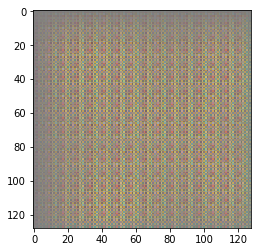

In [24]:
plt.imshow(generated_images[0])

In [ ]:
# plt.plot(gloss_y,gloss_x)

In [ ]:
# with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
#     # saver = tf.train.Saver()
#     sess.run(tf.global_variables_initializer())

#     print("Started training .... !")
    
#     for epoch in range(total_epoch):
#         if(epoch % 10 == 0):
#             print("\nOn epoch {}".format(epoch))
#         for i in range(mnist.train.num_examples//(batch_size*ncritic)):
#             for _ in range(ncritic):
#                 batch_data = mnist.train.next_batch(batch_size=batch_size)
#                 ximage = batch_data[0].reshape((batch_size,image_size,image_size,image_channel))
#                 ximage = convert_to_tanh(ximage)
#                 xsample = np.random.uniform(-1.,1.,size=(batch_size,100))
#                 sess.run([doptimizer,clip_d],feed_dict={real_image:ximage,z:xsample})
#             for _ in range(1):
#                 xsample = np.random.uniform(-1.,1.,size=(batch_size,100))
#                 sess.run(goptimizer,feed_dict={z:xsample})
                
#             if(i%100==0):
#                 l1 = sess.run(dloss,feed_dict={real_image:ximage,z:xsample})
#                 l2 = sess.run(gloss,feed_dict={z:xsample})
#                 #print("after {} losses : Descriptor : {} Generator : {}".format(i,l1,l2))
#                 dloss_x.append(l1)
#                 dloss_y.append(epoch)
#                 gloss_x.append(l2)
#                 gloss_y.append(epoch)
#         cur_sample = np.random.uniform(-1,1,size=(batch_size,100))
#         gen_sample = sess.run(fake_image,feed_dict={z:cur_sample})[0]
#         #gen_sample = unsqueeze_image(np.squeeze(gen_sample)).reshape(28,28)
#         generated_images.append(gen_sample)
#     # saver.save(sess,"./gan/mnist_gan_500.ckpt")